In [1]:
# Instalar librerias

# !pip install yfinance
# !pip install pandas
# !pip install numpy
# !pip install scipy
# !pip install matplotlib

In [2]:
# Importar librerias

import yfinance as yf
import pandas as pd
import numpy as np
import scipy.optimize as sco
import matplotlib.pyplot as plt

In [3]:
# Definir los tickers
tickers = [
    'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA', 'BRK-B', 'JNJ', 'V', 'WMT',
    'PG', 'MA', 'UNH', 'DIS', 'NVDA', 'HD', 'PYPL', 'BAC', 'VZ', 'CMCSA',
    'NFLX', 'ADBE', 'INTC', 'CRM', 'PEP', 'CSCO', 'KO', 'T', 'PFE', 'MRK',
    'ABT', 'ABBV', 'NKE', 'ORCL', 'ACN', 'QCOM', 'TXN', 'AVGO', 'COST', 'DHR',
    'MDT', 'MCD', 'NEE', 'LIN', 'BMY', 'HON', 'LOW', 'UNP', 'UPS', 'SBUX',
    'AMGN', 'TMO', 'CVX', 'XOM', 'BA', 'CAT', 'MMM', 'GE', 'GS', 'JPM',
    'WFC', 'C', 'BLK', 'AXP', 'SPGI', 'RTX', 'DE', 'NOW', 'PLD', 'LMT',
    'CHTR', 'CI', 'CME', 'COP', 'COST', 'D', 'DUK', 'EL', 'EMR',
    'EXC', 'FIS', 'GD', 'GILD', 'GM', 'IBM', 'INTU', 'ISRG', 'LRCX',
    'MO', 'NOC', 'PNC', 'REGN', 'SO', 'SYK', 'TGT', 'TJX', 'USB', 'ZTS'
]

tickers = [
    'SPY',  # S&P 500 ETF
    'IVV',  # iShares Core S&P 500 ETF
    'VOO',  # Vanguard S&P 500 ETF
    'QQQ',  # Nasdaq-100 ETF
    'NDX',  # Nasdaq-100 Index
    'DIA',  # Dow Jones Industrial Average ETF
    'DJI',  # Dow Jones Industrial Average Index
    'VTI',  # Vanguard Total Stock Market ETF
    'IWV',  # Russell 3000 ETF
    'IWM',  # Russell 2000 ETF
    'VT',   # Vanguard Total World Stock ETF
]

tickers = [
    'AAPL',  # Apple Inc.
    'MSFT',  # Microsoft Corporation
    'GOOGL',  # Alphabet Inc.
    'AMZN',  # Amazon.com Inc.
    'NVDA',  # NVIDIA Corporation
    'TSLA',  # Tesla Inc.
    'BRK-B',  # Berkshire Hathaway Inc.
    'META',  # Meta Platforms Inc.
    'V',  # Visa Inc.
    'JPM',  # JPMorgan Chase & Co.
    'WMT',  # Walmart Inc.
    'PG',  # Procter & Gamble Co.
    'MA',  # Mastercard Inc.
    'UNH',  # UnitedHealth Group Inc.
    'HD',  # The Home Depot Inc.
    'BAC',  # Bank of America Corporation
    'XOM',  # Exxon Mobil Corporation
    'CVX',  # Chevron Corporation
    'NFLX',  # Netflix Inc.
    'ADBE',  # Adobe Inc.
    'INTC',  # Intel Corporation
    'TSM',  # Taiwan Semiconductor Manufacturing Company
    'SAP',  # SAP SE
    'ORCL',  # Oracle Corporation
    'NKE',  # NIKE Inc.
    'PFE',  # Pfizer Inc.
    'MRK',  # Merck & Co. Inc.
    'ABBV',  # AbbVie Inc.
    'TMO',  # Thermo Fisher Scientific Inc.
    'ASML',  # ASML Holding N.V.
    'BABA',  # Alibaba Group Holding Ltd.
    'LVMUY',  # LVMH Moët Hennessy Louis Vuitton
    'NSRGY',  # Nestlé S.A.
    'SHEL',  # Shell plc
    'RIO',  # Rio Tinto Group
    'TM',  # Toyota Motor Corporation
    'SNY',  # Sanofi S.A.
    'CSCO',  # Cisco Systems Inc.
    'LIN',  # Linde plc
    'NEE',  # NextEra Energy Inc.
    'LMT',  # Lockheed Martin Corporation
    'RTX',  # RTX Corporation (Raytheon Technologies)
    'DE',  # Deere & Company
    'CAT',  # Caterpillar Inc.
    'HON',  # Honeywell International Inc.
    'UPS',  # United Parcel Service Inc.
    'UNP',  # Union Pacific Corporation
    'SBUX',  # Starbucks Corporation
    'AMGN',  # Amgen Inc.
    'TTE'  # TotalEnergies SE
]

tickers = [
    'GGAL',  # Grupo Financiero Galicia
    'BBAR',  # Banco BBVA Argentina
    'YPF',  # YPF S.A. (Energía)
    'PAM',  # Pampa Energía
    'CEPU',  # Central Puerto S.A. (Generación eléctrica)
    'EDN',  # Edenor (Distribución eléctrica)
    'TGS',  # Transportadora de Gas del Sur
    'LOMA',  # Loma Negra (Cemento)
    'MELI',  # MercadoLibre Inc. (E-commerce y fintech)
    'BMA',  # Banco Macro
    'IRS',  # IRSA (Bienes raíces y shoppings)
    'GGAL'  # Grupo Financiero Galicia
]

# tickers = ['BA', 'XOM', 'GSPC']

# Definir el período de tiempo para los datos históricos
start_date = '2018-01-01'
end_date = '2023-01-01'

In [4]:
# Descargar los datos históricos de los tickers
data = yf.download(tickers, start=start_date, end=end_date)['Close']

# Eliminar las columnas con valores nulos
data.dropna(axis=1, inplace=True)

[*********************100%***********************]  11 of 11 completed


In [5]:
# Calcular los retornos diarios
returns = data.pct_change().dropna()

# Calcular la matriz de covarianza
cov_matrix = returns.cov() * 252

In [6]:
# Función para calcular el rendimiento y la volatilidad de la cartera
def portfolio_performance(weights, returns, cov_matrix):
    ret = np.sum(returns.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return ret, vol

# Función para minimizar la volatilidad de la cartera
def minimize_volatility(weights, returns, cov_matrix):
    return portfolio_performance(weights, returns, cov_matrix)[1]

# Función para maximizar el ratio de Sharpe
def maximize_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate=0.02):
    ret, vol = portfolio_performance(weights, returns, cov_matrix)
    return -(ret - risk_free_rate) / vol

# Función para verificar que la suma de los pesos sea 1
def check_sum(weights):
    return np.sum(weights) - 1

In [7]:
# Número de activos en la cartera
num_assets = len(returns.columns)

# Restricciones y límites para la optimización
constraints = ({'type': 'eq', 'fun': check_sum})
bounds = tuple((0, 1) for _ in range(num_assets))

# Optimización para la cartera de mínima volatilidad
initial_guess = num_assets * [1. / num_assets]
optimal_vol = sco.minimize(minimize_volatility, initial_guess, args=(returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)

# Optimización para la cartera de máximo ratio de Sharpe
optimal_sharpe = sco.minimize(maximize_sharpe_ratio, initial_guess, args=(returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)

In [8]:
# Resultados de la cartera de mínima volatilidad
min_vol_ret, min_vol_vol = portfolio_performance(optimal_vol.x, returns, cov_matrix)
min_vol_weights = dict(zip(returns.columns, optimal_vol.x))
sorted_min_vol_weights = {k: round(v, 3) for k, v in sorted(min_vol_weights.items(), key=lambda item: item[1], reverse=True)}

print("Cartera de Mínima Volatilidad:")
print(f"Retorno Anual: {min_vol_ret:.2%}")
print(f"Volatilidad Anual: {min_vol_vol:.2%}")
print("Pesos de la cartera (ordenados de mayor a menor):")
print(sorted_min_vol_weights)
print(f"Suma de las ponderaciones: {np.sum(optimal_vol.x):.4f}")

# Resultados de la cartera de máximo ratio de Sharpe
max_sharpe_ret, max_sharpe_vol = portfolio_performance(optimal_sharpe.x, returns, cov_matrix)
max_sharpe_weights = dict(zip(returns.columns, optimal_sharpe.x))
sorted_max_sharpe_weights = {k: round(v, 3) for k, v in sorted(max_sharpe_weights.items(), key=lambda item: item[1], reverse=True)}

print("\nCartera de Máximo Ratio de Sharpe:")
print(f"Retorno Anual: {max_sharpe_ret:.2%}")
print(f"Volatilidad Anual: {max_sharpe_vol:.2%}")
print("Pesos de la cartera (ordenados de mayor a menor):")
print(sorted_max_sharpe_weights)
print(f"Suma de las ponderaciones: {np.sum(optimal_sharpe.x):.4f}")

Cartera de Mínima Volatilidad:
Retorno Anual: 8.23%
Volatilidad Anual: 41.32%
Pesos de la cartera (ordenados de mayor a menor):
{'MELI': 0.377, 'IRS': 0.239, 'YPF': 0.129, 'TGS': 0.113, 'LOMA': 0.1, 'EDN': 0.031, 'PAM': 0.011, 'GGAL': 0.0, 'BBAR': 0.0, 'BMA': 0.0}
Suma de las ponderaciones: 1.0000

Cartera de Máximo Ratio de Sharpe:
Retorno Anual: 35.49%
Volatilidad Anual: 57.04%
Pesos de la cartera (ordenados de mayor a menor):
{'MELI': 1.0, 'BMA': 0.0, 'BBAR': 0.0, 'IRS': 0.0, 'GGAL': 0.0, 'YPF': 0.0, 'PAM': 0.0, 'EDN': 0.0, 'LOMA': 0.0, 'TGS': 0.0}
Suma de las ponderaciones: 1.0000


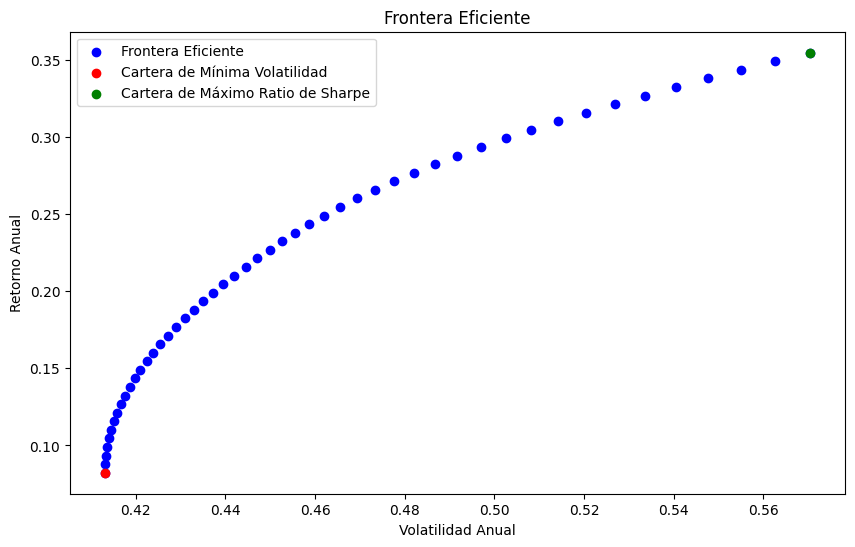

In [9]:
# Función para generar la frontera eficiente
def efficient_frontier(returns, cov_matrix, risk_free_rate=0.02):
    target_returns = np.linspace(min_vol_ret, max_sharpe_ret, 50)
    efficient_portfolios = []
    for target in target_returns:
        constraints = ({'type': 'eq', 'fun': lambda x: portfolio_performance(x, returns, cov_matrix)[0] - target},
                       {'type': 'eq', 'fun': check_sum})
        result = sco.minimize(minimize_volatility, initial_guess, args=(returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)
        efficient_portfolios.append(result)
    return efficient_portfolios

# Generar la frontera eficiente
efficient_portfolios = efficient_frontier(returns, cov_matrix)

# Graficar la frontera eficiente
plt.figure(figsize=(10, 6))
plt.scatter([p['fun'] for p in efficient_portfolios], [portfolio_performance(p.x, returns, cov_matrix)[0] for p in efficient_portfolios], c='blue', label='Frontera Eficiente')
plt.scatter(min_vol_vol, min_vol_ret, c='red', label='Cartera de Mínima Volatilidad')
plt.scatter(max_sharpe_vol, max_sharpe_ret, c='green', label='Cartera de Máximo Ratio de Sharpe')
plt.title('Frontera Eficiente')
plt.xlabel('Volatilidad Anual')
plt.ylabel('Retorno Anual')
plt.legend()
plt.show()